In [7]:
import glob
import numpy as np
import matplotlib.pyplot as plt

### A) Download and unzip the file apples.zip.

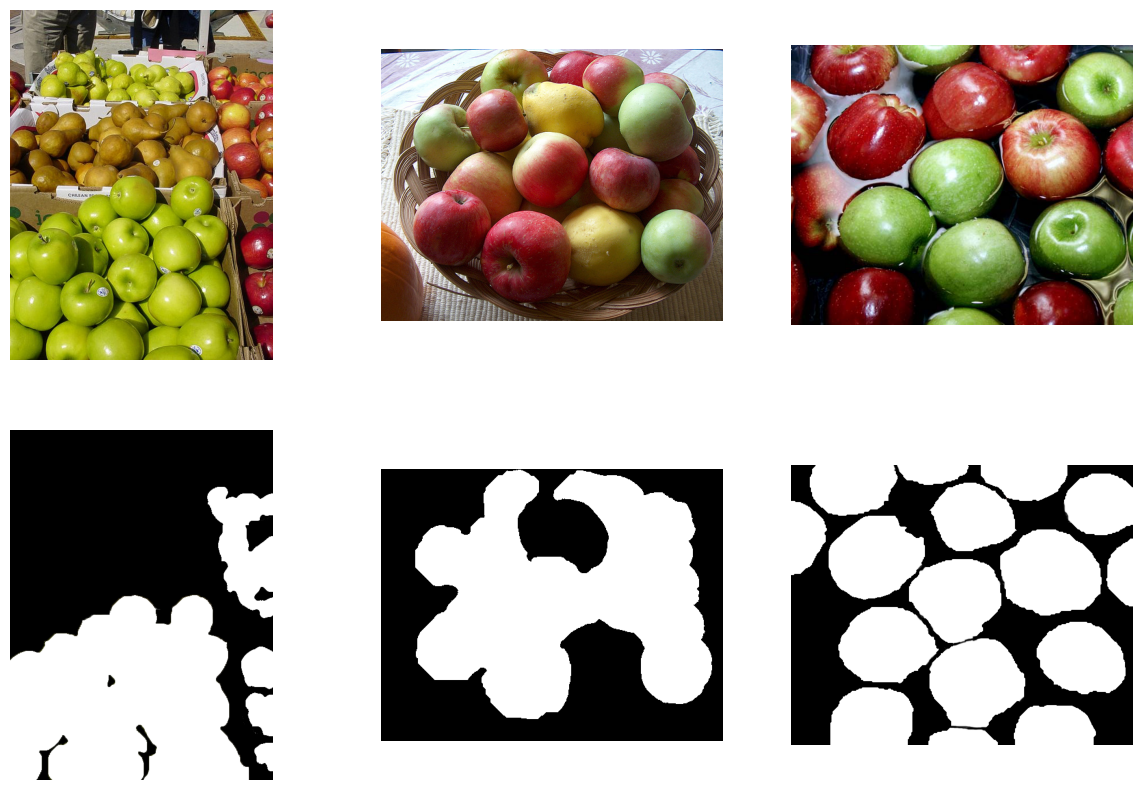

In [8]:
image_list = []
raw_masks = []

# load images
image_files = glob.glob("apples/*.jpg")
image_files.sort()
for cur_img in image_files:
    image = plt.imread(cur_img)
    image_list.append(image)
# load masks
mask_files = glob.glob("apples/*.png")
mask_files.sort()
for cur_mask in mask_files:
    raw = plt.imread(cur_mask)
    if raw.shape[-1] == 4:
        raw = np.delete(raw, -1, axis=-1)
    raw_masks.append(raw)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i in range(len(image_list)):
    axs[i].imshow(image_list[i])
    axs[i+3].imshow(raw_masks[i])
    axs[i].axis('off')
    axs[i+3].axis('off')

plt.show()

### B) Use mixtures of Gaussians to distinguish apple vs. non-apple pixels. Use red, green, and blue as your dimensions for now. Make any other decisions you need to, and document them in your .ipynb notebook

#### [My decisions] The decisions are made as follows:
1. When reading image files and mask files, one mask file provided in the ./apples folder has 4 color channels, so I need to delete the extra channel.
2. After reading these 3 image files, I extract all apple pixels, which are marked by masks as apples, and non-apple pixels into to total_apple_pixels and non_apple_pixels respectively, so that I can train apple MoG and non-apple MoG for Bayes probability calculation at the same time.
3. I vectorize and accelerate the high-load calculation of getMixGaussLoglike() function and E-M steps, because I notice that the lengths of total_apple_pixels and non_apple_pixels are both too large, 424,647 and 375,653. The common iterations over pixels (For example, "for cData in range(nData)" appeared in Part C) could be very inefficient and time-consuming. Training it could cost over 30 minutes. 

   As we all know, the large matrix calculation of NumPy is very efficient because NumPy supports vectorization and broadcasting, which hide operations such as loops and sequence indexing. And these operations are finished by pre-compiled high-performance C code, much faster than the Python code we write.
4. Sometimes, the covariance matrix of pixels' data is invertible and thus we cannot correctly calculate the probability distribution. To solve it, I add 4e-5 * np.identity(cov.shape[0]) to make it invertible when it is invertible and its determinant is zero.

In [9]:
def mask_reshape(data):
    return np.float32(data.reshape(data.shape[0] * data.shape[1], data.shape[2]))

num_images = len(image_list)
total_apple_pixels = np.empty((3, 0))
non_apple_pixels = np.empty((3, 0))
for i in range(num_images):
    reshaped_image = mask_reshape(image_list[i])
    reshaped_mask = np.delete(mask_reshape(raw_masks[i]), [1,2], axis=1).squeeze().astype(int)
    cur_apple_pixels = reshaped_image[reshaped_mask > 0].T / 255.0
    cur_non_apple_pixels = reshaped_image[reshaped_mask == 0].T / 255.0
    total_apple_pixels = np.concatenate((total_apple_pixels, cur_apple_pixels), axis=1)
    non_apple_pixels = np.concatenate((non_apple_pixels, cur_non_apple_pixels), axis=1)

print(total_apple_pixels.shape)
print(non_apple_pixels.shape)

(3, 424647)
(3, 375653)


In [10]:
def multivariate_normal_pdf(x, mu, cov):
    if np.linalg.det(cov) == 0:
        cov += 4e-5 * np.identity(cov.shape[0]) # Need to add small value to singular matrixes in order to make them invertible
    normal_denominator = 1.0 / np.sqrt(np.power((2 * np.pi), x.shape[1]) * np.linalg.det(cov))
    x_mu = np.matrix(x - mu) # (424647, 3)
    x_mu_dot_inv_cov = x_mu @ np.linalg.inv(cov) # (424647, 3)
    exponent = -0.5 * np.sum(np.multiply(x_mu, x_mu_dot_inv_cov), axis=1)
    return (normal_denominator * np.exp(exponent)).reshape(-1)

def getMixGaussLogLike(data, mixGaussEst): 
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.

    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    logLike -- scalar containing the log likelihood.
    """
    
    data = np.atleast_2d(data)
    # find total number of data items
    nDims, nData = data.shape
                   
    # calculate likelihoods for all data points at once
    likelihoods = np.zeros((mixGaussEst['k'], nData))
    for current_gauss in range(mixGaussEst['k']):
        likelihoods[current_gauss, :] = mixGaussEst['weight'][current_gauss] * multivariate_normal_pdf(data.T, mixGaussEst['mean'][:, current_gauss], mixGaussEst['cov'][:, :, current_gauss])
    
    logLike = np.sum(np.log(np.sum(likelihoods, axis=0)))
    
    return logLike

In [11]:
def fitMixGauss(data, k):
    nDims, nData = data.shape
    postHidden = np.zeros(shape=(k, nData))

    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        
    logLike = getMixGaussLogLike(data, mixGaussEst)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))
    nIter = 32
    for cIter in range(nIter):
        # ===================== =====================
        # Expectation step
        for current_gauss in range(k):
            postHidden[current_gauss, :] = mixGaussEst['weight'][current_gauss] * multivariate_normal_pdf(data.T, mixGaussEst['mean'][:, current_gauss], mixGaussEst['cov'][:, :, current_gauss])
        postHidden = postHidden / np.sum(postHidden, axis=0)

        # ===================== =====================
        # Maximization Step
        for cGauss in range(k):
            mixGaussEst['weight'][cGauss] = np.sum(postHidden[cGauss,:]) / np.sum(postHidden)
            mixGaussEst['mean'][:,cGauss] = np.sum(postHidden[cGauss,:] * data, axis=1) / np.sum(postHidden[cGauss,:])
            
            data_diff = data - mixGaussEst['mean'][:, cGauss][:, np.newaxis]
            mixGaussEst['cov'][:, :, cGauss] = np.dot(data_diff * postHidden[cGauss, :], data_diff.T) / np.sum(postHidden[cGauss, :])

        logLike = getMixGaussLogLike(data, mixGaussEst)
        print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))


    return mixGaussEst

In [12]:
# Train
nGaussEst = 7
apple_mog_estimated = fitMixGauss(total_apple_pixels, nGaussEst)
non_apple_mog_estimated = fitMixGauss(non_apple_pixels, nGaussEst) # Used for Bayes rule

Log Likelihood Iter 0 : -1712058.118

Log Likelihood After Iter 0 : 299668.605

Log Likelihood After Iter 1 : 348174.242

Log Likelihood After Iter 2 : 456584.994

Log Likelihood After Iter 3 : 580555.599

Log Likelihood After Iter 4 : 639494.643

Log Likelihood After Iter 5 : 670506.470

Log Likelihood After Iter 6 : 694172.796

Log Likelihood After Iter 7 : 712715.805

Log Likelihood After Iter 8 : 729206.040

Log Likelihood After Iter 9 : 748806.869

Log Likelihood After Iter 10 : 783059.303

Log Likelihood After Iter 11 : 826603.312

Log Likelihood After Iter 12 : 839769.229

Log Likelihood After Iter 13 : 849260.571

Log Likelihood After Iter 14 : 857682.119

Log Likelihood After Iter 15 : 865153.529

Log Likelihood After Iter 16 : 872316.286

Log Likelihood After Iter 17 : 878913.121

Log Likelihood After Iter 18 : 884420.867

Log Likelihood After Iter 19 : 888969.003

Log Likelihood After Iter 20 : 892634.124

Log Likelihood After Iter 21 : 895641.660

Log Likelihood After Iter 

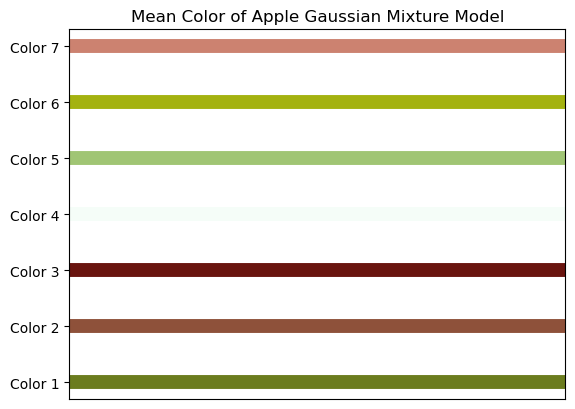

In [13]:
# Mean Color of Apple Gaussian Mixture Model
rgb_color_mog_mean = apple_mog_estimated['mean'].T
fig, ax = plt.subplots()
for i in range(len(rgb_color_mog_mean)):
    ax.axhline(i, color=rgb_color_mog_mean[i], linewidth=10)

ax.set_yticks(range(len(rgb_color_mog_mean)))
ax.set_yticklabels([f"Color {i+1}" for i in range(len(rgb_color_mog_mean))])
ax.set_xticks([])
ax.set_title("Mean Color of Apple Gaussian Mixture Model")
plt.show()

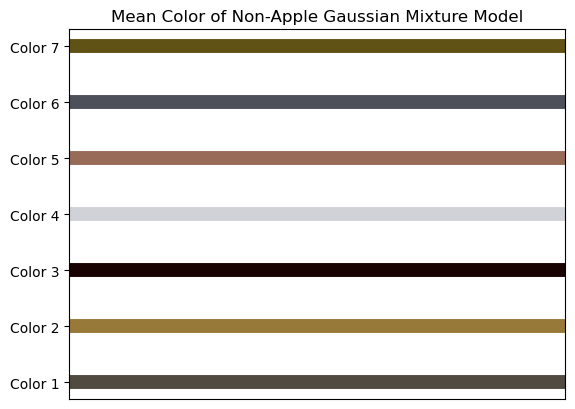

In [14]:
# Mean Color of Non-Apple Gaussian Mixture Model
rgb_color_mog_mean = non_apple_mog_estimated['mean'].T
fig, ax = plt.subplots()
for i in range(len(rgb_color_mog_mean)):
    ax.axhline(i, color=rgb_color_mog_mean[i], linewidth=10)

ax.set_yticks(range(len(rgb_color_mog_mean)))
ax.set_yticklabels([f"Color {i+1}" for i in range(len(rgb_color_mog_mean))])
ax.set_xticks([])
ax.set_title("Mean Color of Non-Apple Gaussian Mixture Model")
plt.show()

### C) Download the file testApples.zip. Generate figures for your notebook, showing each pixel’s posterior probability of being “apple.” Comment on the outcomes

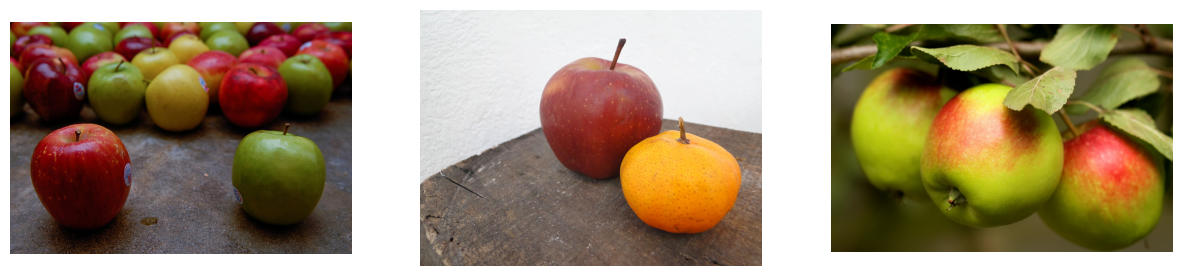

In [15]:
test_images_list = []

# load test images
test_image_files = glob.glob("testApples/*.jpg")
test_image_files.sort()
for cur_img in test_image_files:
    image = plt.imread(cur_img)
    test_images_list.append(image)

# show test images
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
axs = axs.flatten()
for i in range(len(test_images_list)):
    axs[i].imshow(test_images_list[i])
    axs[i].axis('off')

plt.show()

In [16]:
def inference_mask(image_data, apple_mixGaussEst, non_apple_mixGaussEst, threshold=0.5, prior_apple=0.5):
    original_shape = image_data.shape
    image_data = mask_reshape(image_data).T / 255.0
    nDims, nData = image_data.shape
    apple_likelihood = np.zeros((apple_mixGaussEst['k'], nData))
    for current_gauss in range(apple_mixGaussEst['k']):
        apple_likelihood[current_gauss, :] = apple_mixGaussEst['weight'][current_gauss] * multivariate_normal_pdf(image_data.T, apple_mixGaussEst['mean'][:, current_gauss], apple_mixGaussEst['cov'][:, :, current_gauss])
    apple_mask = np.sum(apple_likelihood, axis=0).reshape(original_shape[0], original_shape[1])

    non_apple_likelihood = np.zeros((non_apple_mixGaussEst['k'], nData))
    for current_gauss in range(non_apple_mixGaussEst['k']):
        non_apple_likelihood[current_gauss, :] = non_apple_mixGaussEst['weight'][current_gauss] * multivariate_normal_pdf(image_data.T, non_apple_mixGaussEst['mean'][:, current_gauss], non_apple_mixGaussEst['cov'][:, :, current_gauss])
    non_apple_mask = np.sum(non_apple_likelihood, axis=0).reshape(original_shape[0], original_shape[1])

    prior_non_apple = 1 - prior_apple
    posterior_apple = (apple_mask * prior_apple) / ((apple_mask * prior_apple) + (non_apple_mask * prior_non_apple)) > threshold
    
    return posterior_apple

In [17]:
test_inferences = []
for cur_img in test_images_list:
    test_inferences.append(inference_mask(cur_img, apple_mog_estimated, non_apple_mog_estimated))


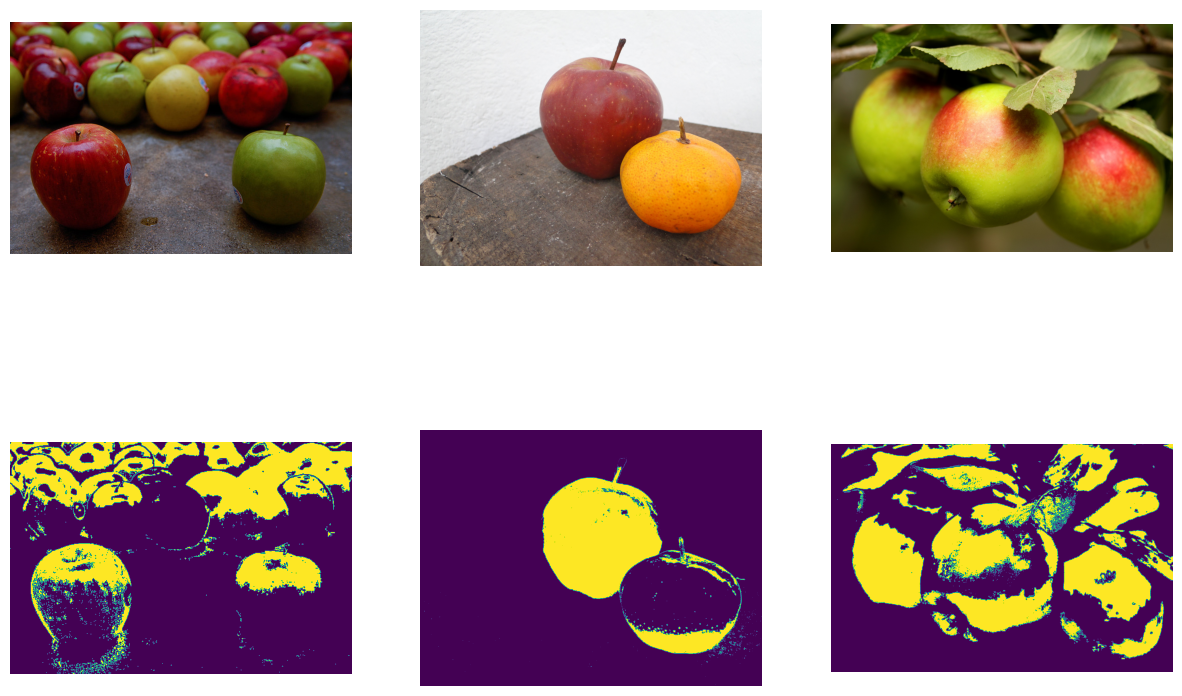

In [18]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i in range(len(test_images_list)):
    axs[i].imshow(test_images_list[i])
    axs[i+3].imshow(test_inferences[i])
    axs[i].axis('off')
    axs[i+3].axis('off')

plt.show()


### - [My Comment]


### D) For the test image with a ground-truth mask, quantify and report your result.
Hint:
consider applying a range of thresholds to the posterior to produce sets of {True Positives
(TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)} and using an
ROC curve. Learn about ROC on Wikipedia or see Peter Flach’s chapter on the subject

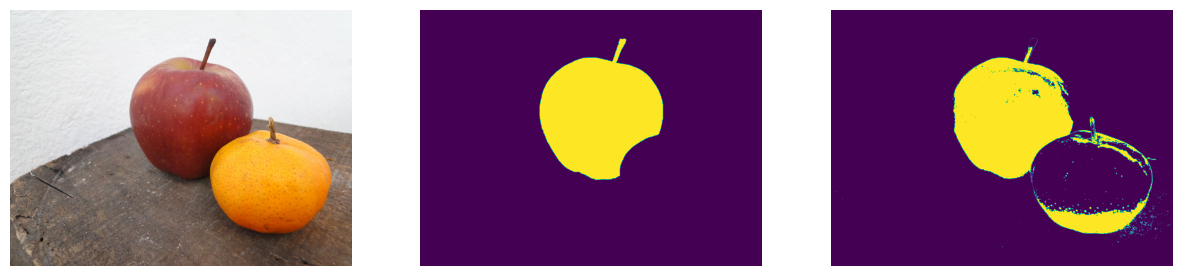

In [19]:
# Read the image Bbr98ad4z0A-ctgXo3gdwu8-original.jpg from testApples folder
test_image_with_gt = plt.imread('testApples/Bbr98ad4z0A-ctgXo3gdwu8-original.jpg')
test_gt_mask = plt.imread('testApples/Bbr98ad4z0A-ctgXo3gdwu8-original.png')
test_gt_mask = np.delete(test_gt_mask, [1,2], axis=2).squeeze().astype(int)
test_with_gt_inference = inference_mask(test_image_with_gt, apple_mog_estimated, non_apple_mog_estimated)

show_images = [test_image_with_gt, test_gt_mask, test_with_gt_inference]
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
axs = axs.flatten()
for i in range(len(show_images)):
    axs[i].imshow(show_images[i])
    axs[i].axis('off')

plt.show()


In [20]:
def calculate_roc(test_image_with_gt, test_gt_mask, apple_mog_estimated, non_apple_mog_estimated):
    tpr_list = []
    fpr_list = []
    threshold_list = np.linspace(0, 1, 20)
    for threshold in threshold_list:
        test_with_gt_inference = inference_mask(test_image_with_gt, apple_mog_estimated, non_apple_mog_estimated, threshold=threshold)
        print(f"Threshold: {threshold}")
        true_pos = np.sum(np.logical_and(test_gt_mask, test_with_gt_inference))
        true_neg = np.sum(np.logical_and(np.logical_not(test_gt_mask), np.logical_not(test_with_gt_inference)))
        false_pos = np.sum(np.logical_and(np.logical_not(test_gt_mask), test_with_gt_inference))
        false_neg = np.sum(np.logical_and(test_gt_mask, np.logical_not(test_with_gt_inference)))

        tpr = true_pos / (true_pos + false_neg)
        fpr = false_pos / (false_pos + true_neg)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        
    return tpr_list, fpr_list



In [21]:
tpr_list, fpr_list = calculate_roc(test_image_with_gt, test_gt_mask, apple_mog_estimated, non_apple_mog_estimated)

Threshold: 0.0
Threshold: 0.05263157894736842
Threshold: 0.10526315789473684
Threshold: 0.15789473684210525
Threshold: 0.21052631578947367
Threshold: 0.2631578947368421
Threshold: 0.3157894736842105
Threshold: 0.3684210526315789
Threshold: 0.42105263157894735
Threshold: 0.47368421052631576
Threshold: 0.5263157894736842
Threshold: 0.5789473684210527
Threshold: 0.631578947368421
Threshold: 0.6842105263157894
Threshold: 0.7368421052631579
Threshold: 0.7894736842105263
Threshold: 0.8421052631578947
Threshold: 0.894736842105263
Threshold: 0.9473684210526315
Threshold: 1.0


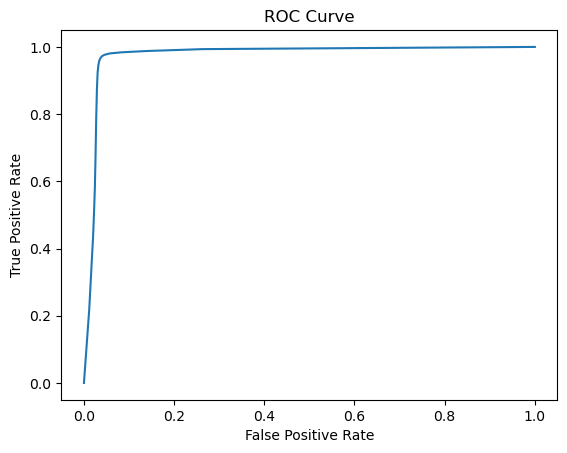

AUC (Area method): 0.974868084150686
AUC (sklearn method): 0.974868084150686


In [22]:
# Plot ROC Curve
roc_list = np.array([tpr_list, fpr_list]).T
plt.plot(roc_list[:, 1], roc_list[:, 0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# Calculate AUC with 2 methods to check
# trapz need to swap the order
roc_list = roc_list[roc_list[:, 1].argsort()]
auc = np.trapz(roc_list[:, 0], roc_list[:, 1])
print(f"AUC: {auc}")


### E) Download or snap two non-copyrighted photos with apples 
(maybe http://search.creativecommons.org/ or some other source of images that are not copyrighted).
Make good ground-truth masks for them. You can use Windows Paint, or more sophisticated
programs like Gimp (free). Use these as extra test-images. Report your qualitative and
quantitative results.

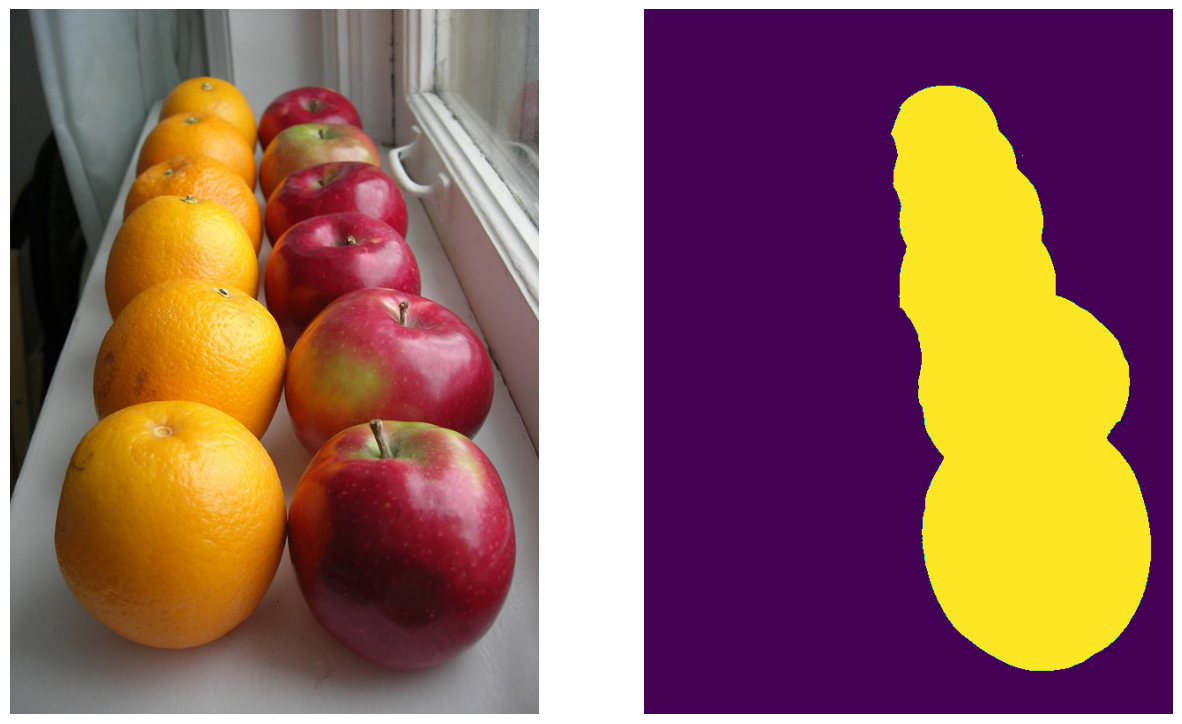

In [23]:
# "Apples and oranges" by Dano is licensed under CC BY 2.0.
apples_oranges = plt.imread('apples_oranges.jpg')
apples_oranges_mask = plt.imread('mask_apples_oranges.png')[:, :, 0]

# show apples_oranges image and mask image
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs = axs.flatten()
axs[0].imshow(apples_oranges)
axs[1].imshow(apples_oranges_mask)
axs[0].axis('off')
axs[1].axis('off')
plt.show()

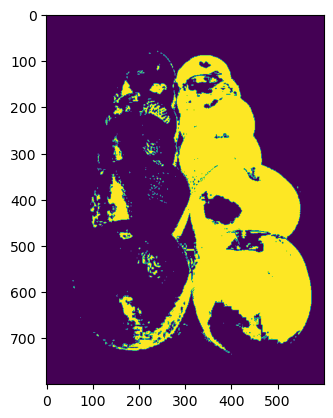

In [24]:
plate_apple_inference = inference_mask(apples_oranges, apple_mog_estimated, non_apple_mog_estimated, threshold=0.5)
plt.imshow(plate_apple_inference)

In [25]:
tpr_list, fpr_list = calculate_roc(apples_oranges, apples_oranges_mask, apple_mog_estimated, non_apple_mog_estimated)

Threshold: 0.0
Threshold: 0.05263157894736842
Threshold: 0.10526315789473684
Threshold: 0.15789473684210525
Threshold: 0.21052631578947367
Threshold: 0.2631578947368421
Threshold: 0.3157894736842105
Threshold: 0.3684210526315789
Threshold: 0.42105263157894735
Threshold: 0.47368421052631576
Threshold: 0.5263157894736842
Threshold: 0.5789473684210527
Threshold: 0.631578947368421
Threshold: 0.6842105263157894
Threshold: 0.7368421052631579
Threshold: 0.7894736842105263
Threshold: 0.8421052631578947
Threshold: 0.894736842105263
Threshold: 0.9473684210526315
Threshold: 1.0


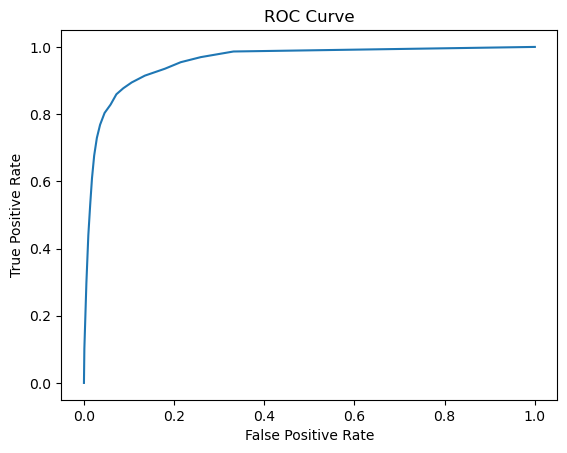

AUC: 0.9570293404780006


In [26]:
roc_list = np.array([tpr_list, fpr_list]).T
plt.plot(roc_list[:, 1], roc_list[:, 0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# Calculate AUC with 2 methods to check
# trapz need to swap the order
roc_list = roc_list[roc_list[:, 1].argsort()]
auc = np.trapz(roc_list[:, 0], roc_list[:, 1])
print(f"AUC: {auc}")

### F) We should really be using three separate sets of files: a training set, a validation set, and a test set! Explain why